

### Libraries Import


In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
from torchvision.transforms import ToTensor, ToPILImage, Resize
import matplotlib.pyplot as plt
import importlib as ipl
import numpy as np
import random
import pickle
import os
import urllib
from timeit import default_timer as timer
import gc
from zipfile import ZipFile

# check the PyTorch version;
print("PyTorch version: ", torch.__version__)
print("torchvision version: ", torchvision.__version__)

# check the GPU support
print("Is GPU available?: ", torch.cuda.is_available())
filepath='RPS'   # for the dataset

PyTorch version:  2.1.1+cu118
torchvision version:  0.16.1+cu118
Is GPU available?:  True


**Dataset downloading**

- Download RPS dataset (https://seafile.unistra.fr/f/2d58c54203e6435fbf22/?dl=1)

In [ ]:
# run to download data

!wget https://seafile.unistra.fr/f/2d58c54203e6435fbf22/?dl=1 --content-disposition &&  unzip -qq RPS.zip -d RPS/

**Data preparation**

In [3]:
# data preprocessing
transform = torchvision.transforms.Compose([
    ToTensor(),
    Resize(size=(224,224)),
])


# full dataset
full_dataset = torchvision.datasets.ImageFolder(root=filepath, transform=transform)
class_names = full_dataset.classes
print("Dataset classes = ", class_names)


# data splitting into train/val/test sets
items = np.random.permutation(len(full_dataset))
val_ratio = 0.1
test_ratio = 0.1
train_items = items[0:int((1.0-val_ratio-test_ratio)*len(full_dataset))]
val_items = items[int((1.0-val_ratio-test_ratio)*len(full_dataset)):int((1.0-test_ratio)*len(full_dataset))]
test_items = items[int((1.0-test_ratio)*len(full_dataset)):-1]
train_dataset = Subset(full_dataset, train_items)
val_dataset = Subset(full_dataset, val_items)
test_dataset = Subset(full_dataset, test_items)


# dataloader for the dataset
BATCH_SIZE = 32
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Creating small dataset here from the train set here for the challenge (containing only 5% of the training set)
train_small_indices = np.random.permutation(train_items[0:int(0.05*len(train_items))])
train_small_dataset = Subset(full_dataset, train_small_indices)
train_small_dataloader = DataLoader(train_small_dataset, batch_size=BATCH_SIZE, shuffle=True)
print("Size: Large train set [{}] vs Small train set [{}]".format(len(train_dataset), len(train_small_dataset)))


Dataset classes =  ['paper', 'rock', 'scissors']
Size: Large train set [1750] vs Small train set [87]


**Data inspection**
- Inspecting the content of one sample of the dataset.

In [4]:
# See pixel values of one image and the label

print(next(iter(train_small_dataloader)))

c:\Users\mubar\Desktop\Year_2\AI\ai_venv\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[tensor([[[[0.1379, 0.1332, 0.1288,  ..., 0.1535, 0.1549, 0.1595],
          [0.1275, 0.1234, 0.1250,  ..., 0.1371, 0.1369, 0.1479],
          [0.1250, 0.1201, 0.1267,  ..., 0.1352, 0.1392, 0.1438],
          ...,
          [0.1240, 0.1221, 0.1217,  ..., 0.1481, 0.1495, 0.1509],
          [0.1221, 0.1232, 0.1226,  ..., 0.1457, 0.1506, 0.1561],
          [0.1248, 0.1216, 0.1249,  ..., 0.1457, 0.1490, 0.1555]],

         [[0.4673, 0.4646, 0.4621,  ..., 0.4706, 0.4687, 0.4764],
          [0.4684, 0.4729, 0.4664,  ..., 0.4782, 0.4786, 0.4776],
          [0.4682, 0.4730, 0.4697,  ..., 0.4805, 0.4848, 0.4759],
          ...,
          [0.4769, 0.4750, 0.4813,  ..., 0.4815, 0.4829, 0.4801],
          [0.4750, 0.4762, 0.4811,  ..., 0.4790, 0.4840, 0.4819],
          [0.4778, 0.4745, 0.4778,  ..., 0.4790, 0.4824, 0.4758]],

         [[0.1693, 0.1666, 0.1641,  ..., 0.1586, 0.1667, 0.1745],
          [0.1666, 0.1682, 0.1702,  ..., 0.1511, 0.1519, 0.1553],
          [0.1655, 0.1671, 0.1738,  ..., 

Previewing sample images from the training set.

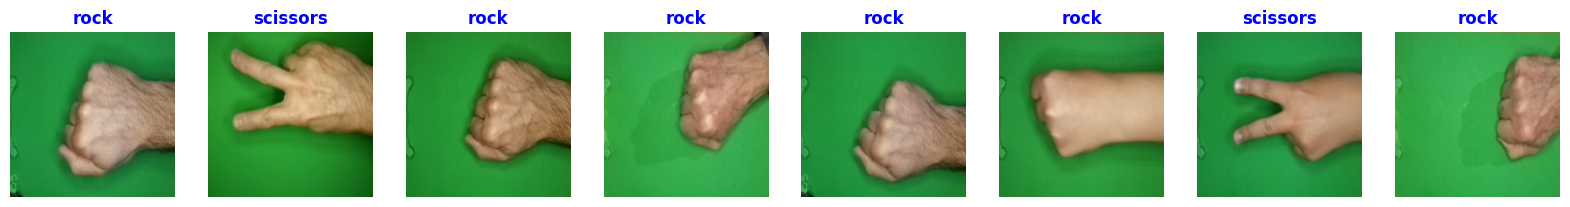

In [5]:
number_of_images = 8
fig, axes = plt.subplots(1, number_of_images, figsize=(20, 20))
# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

#< TODO: Use a plot to show each image and the label as title
for index, axs in enumerate(axes):
    img_out = ToPILImage()(inputs[index])
    class_label = class_names[classes[index]]
    axs.imshow(img_out)
    axs.axis("off")
    axs.set_title(class_label, fontsize=12, color= 'blue', fontweight='bold')
#TODO >



**Model Creation**


In [6]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5)
        self.max_pool_1 = nn.MaxPool2d(kernel_size=5)
        self.conv_2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)
        self.flatten = nn.Flatten()
        self.dense_1 = nn.Linear(in_features=28224, out_features=2048)
        self.dense_2 = nn.Linear(in_features=2048, out_features=4096)
        self.dense_3 = nn.Linear(in_features=4096, out_features=3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv_1(x))
        x = self.max_pool_1(x)
        x = self.relu(self.conv_2(x))
        x = self.flatten(x)
        x = self.relu((self.dense_1(x)))
        x = self.relu((self.dense_2(x)))
        x = self.dense_3(x)
        return x

**Model instantiation**

In [7]:
cnn_0 = CNN()
cnn_0 = cnn_0.to('cuda:0')
# inp = torch.zeros([5,3,224,224]).to('cuda:0') # create "fake" input to run cnn_0 a first time, for allocation (starting point)10
# print("Input type = ", inp.type())
# sample = cnn_0(inp)
# print("Predicted Outputs = ", sample)

**In case of saving the model**

In [8]:
# save checkpoint
# torch.save({
#             'model_state_dict': cnn_0.state_dict(),
#             }, 'untrained')

**A function for model initialization**

In [9]:
def get_new_model(lr):
    new_cnn = CNN()
    new_optimizer = torch.optim.SGD(new_cnn.parameters(), lr=lr)
    startpoint = torch.load('untrained')
    new_cnn.load_state_dict(startpoint['model_state_dict'])
    new_cnn = new_cnn.to('cuda:0')
    return new_cnn, new_optimizer

**Model overview**

In [10]:
from torchsummary import summary
summary(cnn_0, (3, 224, 224))    # provide "summary" with model and input data size 


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 220, 220]             608
              ReLU-2          [-1, 8, 220, 220]               0
         MaxPool2d-3            [-1, 8, 44, 44]               0
            Conv2d-4           [-1, 16, 42, 42]           1,168
              ReLU-5           [-1, 16, 42, 42]               0
           Flatten-6                [-1, 28224]               0
            Linear-7                 [-1, 2048]      57,804,800
              ReLU-8                 [-1, 2048]               0
            Linear-9                 [-1, 4096]       8,392,704
             ReLU-10                 [-1, 4096]               0
           Linear-11                    [-1, 3]          12,291
Total params: 66,211,571
Trainable params: 66,211,571
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Fo

Training and evaluation function

In [14]:
LEARNING_RATE = 0.005
optimizer = torch.optim.SGD(cnn_0.parameters(), lr=LEARNING_RATE)

def train_step(inputs, labels, cnn_model, optim):
    cnn_model.train()
    data = inputs.to('cuda:0')
    #TODO: optimizer zero gradient <
    optim.zero_grad()
    #>
    outp = cnn_model(data)
    loss = torch.mean(torch.nn.CrossEntropyLoss()(outp.to('cpu'), labels))
    #TODO: write the two steps of optimization <
    # backward
    loss.backward()
    # optimize
    optim.step()  #Updates the parameters of the model based on the computed gradients

    #>
    del data
    del outp
    torch.cuda.empty_cache()
    return loss.item()

In [ ]:
def eval_step(inputs, labels, cnn_model):
    cnn_model.eval()
    data = inputs.to('cuda:0')
    outp = cnn_model(data)
    pred = torch.argmax(outp, axis=1)
    acc = torch.mean((labels == pred.to('cpu')).float())
    del data
    del pred
    torch.cuda.empty_cache()
    return acc

Model training for 2000 iterations.
- Average training loss and validation accuracy is reported at every 100-th iteration.
- Then plotted after iterations are complete.

ITER 000100: training loss = 1.0975 | [EVAL]: validation accuracy = 0.3431
____________________________________________________________________________________________________
ITER 000200: training loss = 1.0939 | [EVAL]: validation accuracy = 0.3805
____________________________________________________________________________________________________
ITER 000300: training loss = 1.0874 | [EVAL]: validation accuracy = 0.5319
____________________________________________________________________________________________________
ITER 000400: training loss = 1.0644 | [EVAL]: validation accuracy = 0.6887
____________________________________________________________________________________________________
ITER 000500: training loss = 0.9531 | [EVAL]: validation accuracy = 0.7860
____________________________________________________________________________________________________
ITER 000600: training loss = 0.6697 | [EVAL]: validation accuracy = 0.8084
_____________________________________________

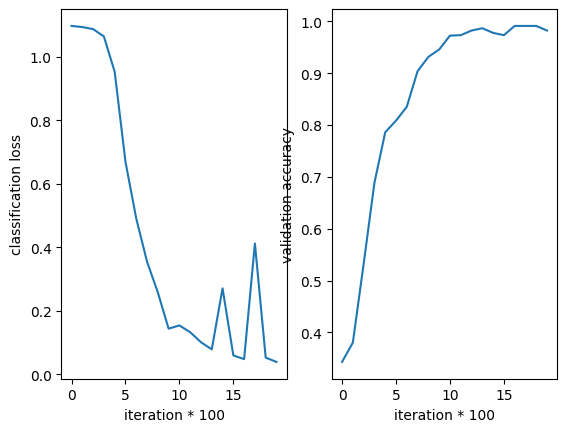

In [15]:
average_training_losses = []
average_val_accs = []

iteration = 0
log_iter = 100 # TODO
max_iter = 2000# TODO
epochs = 10000
stopped = False
start_t = timer()


#TODO : restart model
cnn_0, optimizer = get_new_model(lr=LEARNING_RATE)
#>

for epoch in range(epochs):
    training_losses = []
    for (x_train_in, y_train_in) in train_dataloader:#TODO: train data loader
        iteration += 1
        loss = train_step(x_train_in, y_train_in, cnn_0, optimizer)
        training_losses.append(loss)

        if iteration % log_iter == 0:
            avg_loss = sum(training_losses) / len(training_losses)
            average_training_losses.append(avg_loss)
            training_losses = []

            val_accs = []
            for x_val_in, y_val_in in val_dataloader:
                acc = eval_step(x_val_in, y_val_in, cnn_0)
                val_accs.append(acc)
            avg_acc = sum(val_accs) / len(val_accs)
            average_val_accs.append(avg_acc)

            print("ITER {:0>6d}: training loss = {:.4f} | [EVAL]: validation accuracy = {:.4f}".format(iteration, avg_loss, avg_acc))
            print("_"*100)

        if iteration >= max_iter:
            stopped = True
            break
    if stopped:
      break


end_t = timer()
print("time_elapsed: {}".format(end_t - start_t))

fig = plt.figure()

ax = fig.add_subplot(121)
intervals = np.arange(len(average_training_losses))
ax.plot(intervals, average_training_losses)
ax.set_xlabel("iteration * {}".format(log_iter))
ax.set_ylabel("classification loss")

ax = fig.add_subplot(122)
intervals = np.arange(len(average_val_accs))
ax.plot(intervals, average_val_accs)
ax.set_xlabel("iteration * {}".format(log_iter))
ax.set_ylabel("validation accuracy")

print("Evaluation accuracy = ", average_val_accs[-1])

# clear GPU cache memory
torch.cuda.empty_cache()


Evaluating the trained model on the training set, then on the test set.

In [16]:
train_accs = []
for x_train_in, y_train_in in train_dataloader:
    #TODO: evaluate on train data <
    acc = eval_step(x_train_in, y_train_in, cnn_0)
    train_accs.append(acc)
    #>
average_train_acc = sum(train_accs) / len(train_accs)
print("ACCURACY - TRAINING SET: {}".format(average_train_acc))


test_accs = []
for x_test_in, y_test_in in test_dataloader:
    #TODO: evaluate on test data <
    acc = eval_step(x_test_in, y_test_in, cnn_0)
    test_accs.append(acc)
    #>
average_test_acc = sum(test_accs) / len(test_accs)
print("ACCURACY - TEST SET: {}".format(average_test_acc))

ACCURACY - TRAINING SET: 0.9960227012634277
ACCURACY - TEST SET: 0.9766483306884766


### Now for the small training dataset (5% of the training set)

- Retraining the model on the smaller training data (5% of train data)

ITER 000100: training loss = 1.0985 | [EVAL]: validation accuracy = 0.3431
____________________________________________________________________________________________________
ITER 000200: training loss = 1.0893 | [EVAL]: validation accuracy = 0.3431
____________________________________________________________________________________________________
ITER 000300: training loss = 1.0777 | [EVAL]: validation accuracy = 0.3431
____________________________________________________________________________________________________
ITER 000400: training loss = 1.0405 | [EVAL]: validation accuracy = 0.3967
____________________________________________________________________________________________________
ITER 000500: training loss = 0.7549 | [EVAL]: validation accuracy = 0.7077
____________________________________________________________________________________________________
ITER 000600: training loss = 0.3128 | [EVAL]: validation accuracy = 0.7779
_____________________________________________

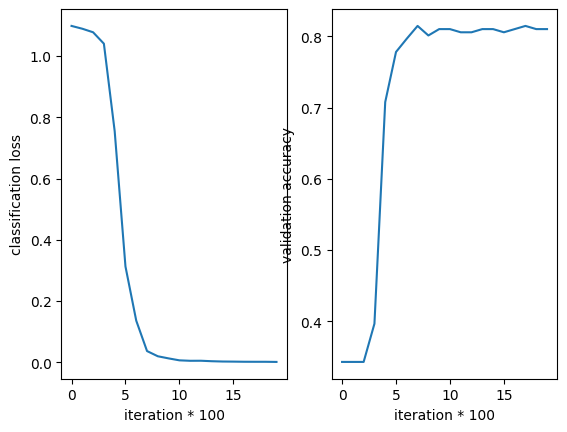

In [17]:
average_training_losses = []
average_val_accs = []

iteration = 0
log_iter = 100
max_iter = 2000
epochs = 10000
stopped = False
start_t = timer()


# TODO:  restart model <
cnn_0, optimizer = get_new_model(lr=LEARNING_RATE)
#>

for epoch in range(epochs):
    training_losses = []
    for (x_train_in, y_train_in) in train_small_dataloader:# TODO: right dataset loader
        iteration += 1
        loss = train_step(x_train_in, y_train_in, cnn_0, optimizer)
        training_losses.append(loss)

        if iteration % log_iter == 0:
            avg_loss = sum(training_losses) / len(training_losses)
            average_training_losses.append(avg_loss)
            training_losses = []

            val_accs = []
            for x_val_in, y_val_in in val_dataloader:
                acc = eval_step(x_val_in, y_val_in, cnn_0)
                val_accs.append(acc)
            avg_acc = sum(val_accs) / len(val_accs)
            average_val_accs.append(avg_acc)

            print("ITER {:0>6d}: training loss = {:.4f} | [EVAL]: validation accuracy = {:.4f}".format(iteration, avg_loss, avg_acc))
            print("_"*100)

        if iteration >= max_iter:
            stopped = True
            break
    if stopped:
        break


end_t = timer()
print("time_elapsed: {}".format(end_t - start_t))

fig = plt.figure()

ax = fig.add_subplot(121)
intervals = np.arange(len(average_training_losses))
ax.plot(intervals, average_training_losses)
ax.set_xlabel("iteration * {}".format(log_iter))
ax.set_ylabel("classification loss")

ax = fig.add_subplot(122)
intervals = np.arange(len(average_val_accs))
ax.plot(intervals, average_val_accs)
ax.set_xlabel("iteration * {}".format(log_iter))
ax.set_ylabel("validation accuracy")

print("Evaluation accuracy = ", average_val_accs[-1])

# TODO: clear GPU cache memory <
torch.cuda.empty_cache()
#>

Evaluating the small dataset trained model on the small training set, then on the test set

- Observation: performance of the model for the small training set is lesser

In [18]:
train_accs = []
for x_train_in, y_train_in in train_small_dataloader:
    acc = eval_step(x_train_in, y_train_in, cnn_0)
    train_accs.append(acc)

average_train_acc = sum(train_accs) / len(train_accs)
print("ACCURACY - TRAINING SET: {}".format(average_train_acc))


test_accs = []
for x_test_in, y_test_in in test_dataloader:
    acc = eval_step(x_test_in, y_test_in, cnn_0)
    test_accs.append(acc)

average_test_acc = sum(test_accs) / len(test_accs)
print("ACCURACY - TEST SET: {}".format(average_test_acc))

ACCURACY - TRAINING SET: 1.0
ACCURACY - TEST SET: 0.7973901033401489


# Performance improvement (The Challenge)

**Task**
- Improving the performance of the model on the small training set
- This case can be encountered in real-world problems where there labels on data are scare, especially in the medical imaging domain*



**The challenge**
- Improving the performance of the model to achieve at least 95% accuracy on test data

### Countermeasure 1 - Data Augmentation

In [19]:
# Data preprocessing:  
transform_rand = torchvision.transforms.Compose([

    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomVerticalFlip(),
    torchvision.transforms.RandomRotation(45),
    
    torchvision.transforms.ToTensor(),
    
    
    # Add data preprocessing (normalization)
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  
    #>
    Resize(size=(224,224)),
])

# full dataset
full_dataset = torchvision.datasets.ImageFolder(root=filepath, transform=transform_rand)
class_names = full_dataset.classes
print("Dataset classes = ", class_names)


# split data into train/val/test sets
items = np.random.permutation(len(full_dataset))
val_ratio = 0.1
test_ratio = 0.1
train_items = items[0:int((1.0-val_ratio-test_ratio)*len(full_dataset))]
train_dataset = Subset(full_dataset, train_items)


# build a dataloader for the dataset
BATCH_SIZE = 22         
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# lets create a small dataset from the train set (containing only 5% of the train set)
train_small_indices = np.random.permutation(train_items[0:int(0.05*len(train_items))])
train_small_dataset = Subset(full_dataset, train_small_indices)
train_small_aug_dataloader = DataLoader(train_small_dataset, batch_size=BATCH_SIZE, shuffle=True)
print("Size: Large train set [{}] vs Small train set [{}]".format(len(train_dataset), len(train_small_dataset)))

print((train_small_dataset[0][0].shape))

Dataset classes =  ['paper', 'rock', 'scissors']
Size: Large train set [1750] vs Small train set [87]
torch.Size([3, 224, 224])


In [20]:
# Applying the normalization on the validation set

# mean and std values
val_data_norm  = []
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

# Apply normalization to the dataset
for i in range(len(val_dataset)):
    image, label = val_dataset[i]
    image = (image - mean[:, None, None]) / std[:, None, None]
    val_data_norm.append((image, label))

# Separate images and labels
modified_images, modified_labels = zip(*val_data_norm)

# Convert the lists to tensors
modified_images_tensor = torch.stack(modified_images)
modified_labels_tensor = torch.tensor(modified_labels)

# Create a TensorDataset
modified_dataset = torch.utils.data.TensorDataset(modified_images_tensor, modified_labels_tensor)

# Create a DataLoader
norm_val_dataloader = DataLoader(modified_dataset, batch_size=BATCH_SIZE, shuffle=False)

**Training on data augmentation**


ITER 000100: training loss = 1.0812 | [EVAL]: validation accuracy = 0.3429
____________________________________________________________________________________________________
ITER 000200: training loss = 1.0314 | [EVAL]: validation accuracy = 0.4485
____________________________________________________________________________________________________
ITER 000300: training loss = 1.0388 | [EVAL]: validation accuracy = 0.7355
____________________________________________________________________________________________________
ITER 000400: training loss = 0.7958 | [EVAL]: validation accuracy = 0.6942
____________________________________________________________________________________________________
ITER 000500: training loss = 0.7067 | [EVAL]: validation accuracy = 0.5983
____________________________________________________________________________________________________
ITER 000600: training loss = 0.5866 | [EVAL]: validation accuracy = 0.8221
_____________________________________________

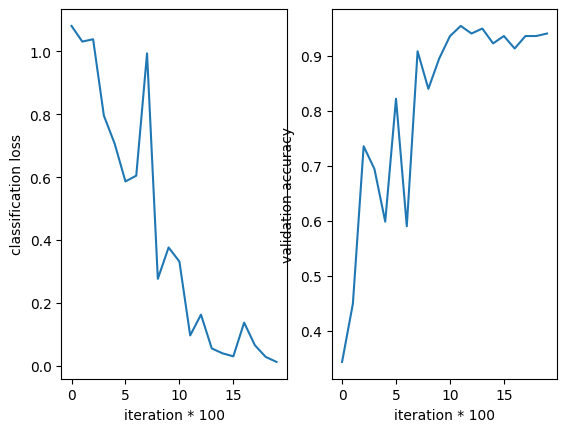

In [21]:

average_training_losses = []
average_val_accs = []

iteration = 0
log_iter = 100
max_iter = 2000
epochs = 10000
stopped = False
start_t = timer()

# TODO: restart model
cnn_0, optimizer = get_new_model(lr=LEARNING_RATE)


# TODO: write the training loop (make sure to use 'train_small_aug_dataloader') <
for epoch in range(epochs):
    training_losses = []
    for (x_train_in, y_train_in) in train_small_aug_dataloader:# TODO: right dataset loader
        iteration += 1
        loss = train_step(x_train_in, y_train_in, cnn_0, optimizer)
        training_losses.append(loss)

        if iteration % log_iter == 0:
            avg_loss = sum(training_losses) / len(training_losses)
            average_training_losses.append(avg_loss)
            training_losses = []

            val_accs = []
            for x_val_in, y_val_in in norm_val_dataloader:
                acc = eval_step(x_val_in, y_val_in, cnn_0)
                val_accs.append(acc)
            avg_acc = sum(val_accs) / len(val_accs)
            average_val_accs.append(avg_acc)

            print("ITER {:0>6d}: training loss = {:.4f} | [EVAL]: validation accuracy = {:.4f}".format(iteration, avg_loss, avg_acc))
            print("_"*100)

        if iteration >= max_iter:
            stopped = True
            break
    if stopped:
        break

#>

end_t = timer()
print("time_elapsed: {}".format(end_t - start_t))

fig = plt.figure()

ax = fig.add_subplot(121)
intervals = np.arange(len(average_training_losses))
ax.plot(intervals, average_training_losses)
ax.set_xlabel("iteration * {}".format(log_iter))
ax.set_ylabel("classification loss")

ax = fig.add_subplot(122)
intervals = np.arange(len(average_val_accs))
ax.plot(intervals, average_val_accs)
ax.set_xlabel("iteration * {}".format(log_iter))
ax.set_ylabel("validation accuracy")

print("Evaluation accuracy = ", average_val_accs[-1])

# clear GPU cache memory
torch.cuda.empty_cache()

In [22]:
# TODO: write the testing loop on the train small data <

train_accs = []
for x_train_in, y_train_in in train_small_aug_dataloader:
    acc = eval_step(x_train_in, y_train_in, cnn_0)
    train_accs.append(acc)

average_train_acc = sum(train_accs) / len(train_accs)
print("ACCURACY - TRAINING SET: {}".format(average_train_acc))


#> 
# Normalizing the Test Dataset
test_data_norm  = []
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

for i in range(len(test_dataset)):
    image, label = test_dataset[i]
    image = (image - mean[:, None, None]) / std[:, None, None]
    test_data_norm.append((image, label))

# Separate images and labels
modified_images, modified_labels = zip(*test_data_norm)

# Convert the lists to tensors
modified_images_tensor = torch.stack(modified_images)
modified_labels_tensor = torch.tensor(modified_labels)

# Create a TensorDataset
modified_dataset = torch.utils.data.TensorDataset(modified_images_tensor, modified_labels_tensor)

# Create a DataLoader
norm_test_dataloader = DataLoader(modified_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ===== End of Normalization ====


# TODO: write the testing loop on the test data <
test_accs = []
for x_test_in, y_test_in in norm_test_dataloader:
    acc = eval_step(x_test_in, y_test_in, cnn_0)
    test_accs.append(acc)

average_test_acc = sum(test_accs) / len(test_accs)
print("ACCURACY - TEST SET: {}".format(average_test_acc))
#>

# =============== Observation: 93% on Data Augmentation ===============

ACCURACY - TRAINING SET: 0.9886363744735718
ACCURACY - TEST SET: 0.9313637018203735


### Countermeasure 2 - Data Augmentation + Regularization

In [23]:
# Regularization in addition to the previous approach (augmentation)

def get_new_model(lr):
    new_cnn = CNN()
    new_optimizer = torch.optim.SGD(new_cnn.parameters(), lr=lr, weight_decay=1e-5)
    startpoint = torch.load('untrained')
    new_cnn.load_state_dict(startpoint['model_state_dict'])
    new_cnn = new_cnn.to('cuda:0')
    return new_cnn, new_optimizer

ITER 000100: training loss = 1.0811 | [EVAL]: validation accuracy = 0.3429
____________________________________________________________________________________________________
ITER 000200: training loss = 1.0242 | [EVAL]: validation accuracy = 0.4074
____________________________________________________________________________________________________
ITER 000300: training loss = 0.9094 | [EVAL]: validation accuracy = 0.6853
____________________________________________________________________________________________________
ITER 000400: training loss = 0.7403 | [EVAL]: validation accuracy = 0.7719
____________________________________________________________________________________________________
ITER 000500: training loss = 0.6280 | [EVAL]: validation accuracy = 0.8173
____________________________________________________________________________________________________
ITER 000600: training loss = 0.5119 | [EVAL]: validation accuracy = 0.8126
_____________________________________________

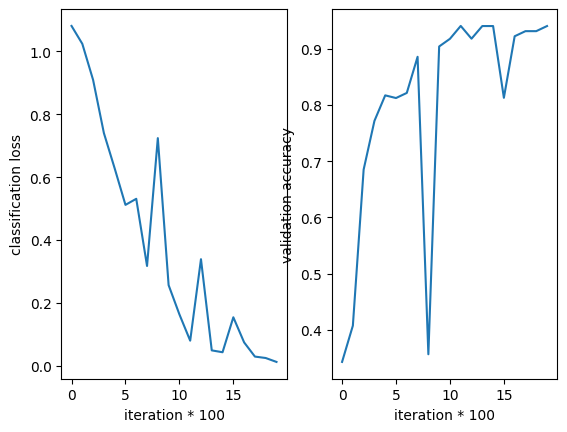

In [24]:
# Strateg 1 T0-DO: Applying Regularization on the previous Augmented Approach

average_training_losses = []
average_val_accs = []

iteration = 0
log_iter = 100 # TODO
max_iter = 2000# TODO
epochs = 10000
stopped = False
start_t = timer()


#TODO : restart model
cnn_0, optimizer = get_new_model(lr=LEARNING_RATE)
#>

for epoch in range(epochs):
    training_losses = []
    for (x_train_in, y_train_in) in train_small_aug_dataloader:#TODO: train data loader
        iteration += 1
        loss = train_step(x_train_in, y_train_in, cnn_0, optimizer)
        training_losses.append(loss)

        if iteration % log_iter == 0:
            avg_loss = sum(training_losses) / len(training_losses)
            average_training_losses.append(avg_loss)
            training_losses = []

            val_accs = []
            for x_val_in, y_val_in in norm_val_dataloader:
                acc = eval_step(x_val_in, y_val_in, cnn_0)
                val_accs.append(acc)
            avg_acc = sum(val_accs) / len(val_accs)
            average_val_accs.append(avg_acc)

            print("ITER {:0>6d}: training loss = {:.4f} | [EVAL]: validation accuracy = {:.4f}".format(iteration, avg_loss, avg_acc))
            print("_"*100)

        if iteration >= max_iter:
            stopped = True
            break
    if stopped:
      break


end_t = timer()
print("time_elapsed: {}".format(end_t - start_t))

fig = plt.figure()

ax = fig.add_subplot(121)
intervals = np.arange(len(average_training_losses))
ax.plot(intervals, average_training_losses)
ax.set_xlabel("iteration * {}".format(log_iter))
ax.set_ylabel("classification loss")

ax = fig.add_subplot(122)
intervals = np.arange(len(average_val_accs))
ax.plot(intervals, average_val_accs)
ax.set_xlabel("iteration * {}".format(log_iter))
ax.set_ylabel("validation accuracy")

print("Evaluation accuracy = ", average_val_accs[-1])

# clear GPU cache memory
torch.cuda.empty_cache()

In [25]:
# Testing on train and test data

train_accs = []
for x_train_in, y_train_in in train_small_aug_dataloader:
    acc = eval_step(x_train_in, y_train_in, cnn_0)
    train_accs.append(acc)

average_train_acc = sum(train_accs) / len(train_accs)
print("ACCURACY - TRAINING SET: {}".format(average_train_acc))


# TODO: write the testing loop on the test data <
test_accs = []
for x_test_in, y_test_in in norm_test_dataloader:
    acc = eval_step(x_test_in, y_test_in, cnn_0)
    test_accs.append(acc)

average_test_acc = sum(test_accs) / len(test_accs)
print("ACCURACY - TEST SET: {}".format(average_test_acc))
#>

# Observation: 92% Performance on Test data (drops by 1%)

ACCURACY - TRAINING SET: 1.0
ACCURACY - TEST SET: 0.9268181920051575


### Countermeasure 3 - Dropout + Batch Normalization + Augmentation + hyperparameter tuning

In [26]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5) 
        self.max_pool_1 = nn.MaxPool2d(kernel_size=5) 
        self.conv_2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)
        self.bnorm =  nn.BatchNorm2d(16)
        self.flatten = nn.Flatten()
        self.dense_1 = nn.Linear(in_features=28224, out_features=2048)
        self.dense_2 = nn.Linear(in_features=2048, out_features=4096)
        self.bnorm2 = nn.BatchNorm1d(4096)
        self.dense_3 = nn.Linear(in_features=4096, out_features=3)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.20)

        # Applying He initialization to convolutional layers
        nn.init.kaiming_normal_(self.conv_1.weight.data, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv_2.weight.data, mode='fan_in', nonlinearity='relu')

        # Apply He initialization to linear layers
        nn.init.kaiming_normal_(self.dense_1.weight.data, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_normal_(self.dense_2.weight.data, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_normal_(self.dense_3.weight.data, mode='fan_in', nonlinearity='relu')


    def forward(self, x):
        x = self.relu(self.conv_1(x))
        x = self.max_pool_1(x)
        x = self.relu(self.conv_2(x))
        x = self.bnorm(x) 
        x = self.flatten(x)
        x = self.relu((self.dense_1(x)))
        x = self.relu((self.dense_2(x)))
        x = self.bnorm2(x) 
        x = self.dropout(x)
        x = self.dense_3(x)
        return x

def get_new_model(lr):
    new_cnn = CNN()
    new_optimizer = torch.optim.SGD(new_cnn.parameters(), lr=lr)
    startpoint = torch.load('check')
    new_cnn.load_state_dict(startpoint['model_state_dict'])
    new_cnn = new_cnn.to('cuda:0')
    return new_cnn, new_optimizer

ITER 000100: training loss = 0.3103 | [EVAL]: validation accuracy = 0.8861
____________________________________________________________________________________________________
ITER 000200: training loss = 0.0908 | [EVAL]: validation accuracy = 0.9045
____________________________________________________________________________________________________
ITER 000300: training loss = 0.0730 | [EVAL]: validation accuracy = 0.9318
____________________________________________________________________________________________________
ITER 000400: training loss = 0.0825 | [EVAL]: validation accuracy = 0.9364
____________________________________________________________________________________________________
ITER 000500: training loss = 0.0168 | [EVAL]: validation accuracy = 0.9409
____________________________________________________________________________________________________
ITER 000600: training loss = 0.0215 | [EVAL]: validation accuracy = 0.9271
_____________________________________________

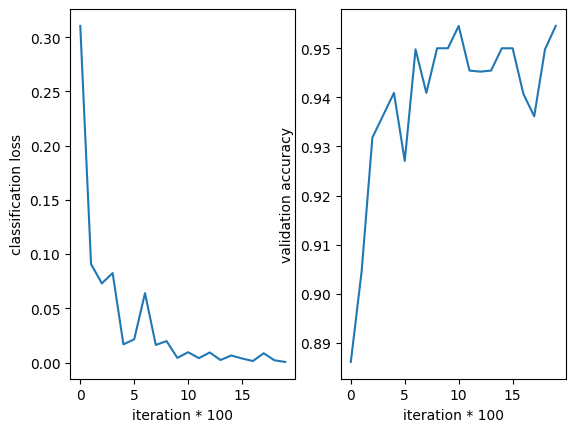

In [27]:
average_training_losses = []
average_val_accs = []

iteration = 0
log_iter = 100 # TODO
max_iter = 2000# TODO
epochs = 10000
stopped = False
start_t = timer()

LEARNING_RATE = 0.004

#TODO : restart model
cnn_0, optimizer = get_new_model(lr=LEARNING_RATE)
#>

for epoch in range(epochs):
    training_losses = []
    for (x_train_in, y_train_in) in train_small_aug_dataloader:#TODO: train data loader
        iteration += 1
        loss = train_step(x_train_in, y_train_in, cnn_0, optimizer)
        training_losses.append(loss)

        if iteration % log_iter == 0:
            avg_loss = sum(training_losses) / len(training_losses)
            average_training_losses.append(avg_loss)
            training_losses = []

            val_accs = []
            for x_val_in, y_val_in in norm_val_dataloader:
                acc = eval_step(x_val_in, y_val_in, cnn_0)
                val_accs.append(acc)
            avg_acc = sum(val_accs) / len(val_accs)
            average_val_accs.append(avg_acc)

            # Early Stopping 
            if avg_acc >= 0.98 and avg_loss < 0.01:
                stopped = True
                break

            print("ITER {:0>6d}: training loss = {:.4f} | [EVAL]: validation accuracy = {:.4f}".format(iteration, avg_loss, avg_acc))
            print("_"*100)

        if iteration >= max_iter:
            stopped = True
            break
    if stopped:
      break


end_t = timer()
print("time_elapsed: {}".format(end_t - start_t))

fig = plt.figure()

ax = fig.add_subplot(121)
intervals = np.arange(len(average_training_losses))
ax.plot(intervals, average_training_losses)
ax.set_xlabel("iteration * {}".format(log_iter))
ax.set_ylabel("classification loss")

ax = fig.add_subplot(122)
intervals = np.arange(len(average_val_accs))
ax.plot(intervals, average_val_accs)
ax.set_xlabel("iteration * {}".format(log_iter))
ax.set_ylabel("validation accuracy")

print("Evaluation accuracy = ", average_val_accs[-1])

# clear GPU cache memory
torch.cuda.empty_cache()

In [28]:
# Testing with the trained model
train_accs = []
for x_train_in, y_train_in in train_small_aug_dataloader:
    acc = eval_step(x_train_in, y_train_in, cnn_0)
    train_accs.append(acc)

average_train_acc = sum(train_accs) / len(train_accs)
print("ACCURACY - TRAINING SET: {}".format(average_train_acc))


# TODO: write the testing loop on the test data <
test_accs = []
for x_test_in, y_test_in in norm_test_dataloader:
    acc = eval_step(x_test_in, y_test_in, cnn_0)
    test_accs.append(acc)

average_test_acc = sum(test_accs) / len(test_accs)
print("ACCURACY - TEST SET: {}".format(average_test_acc)) 


# Observation: 96% accuracy on Test data

ACCURACY - TRAINING SET: 1.0
ACCURACY - TEST SET: 0.9631817936897278
